In [1]:
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path
from gmm.base_models.general_ou import OU
from gmm.models.ou_gmm import OU_GMM
sys.executable

'C:\\Users\\Os\\AppData\\Local\\Programs\\Python\\Python310\\python.exe'

In [3]:
data_path = Path('gmm/datas/global_equity_ticker.csv')
df = pd.read_csv(data_path)
df.head

<bound method NDFrame.head of                  ID        DATE CURRENCY   PX_LAST
0      MEXBOL Index  2021-01-25      MXN  45126.52
1      MEXBOL Index  2021-01-26      MXN  45053.56
2      MEXBOL Index  2021-01-27      MXN  44262.01
3      MEXBOL Index  2021-01-28      MXN  44280.73
4      MEXBOL Index  2021-01-29      MXN  42985.73
...             ...         ...      ...       ...
36535     SMI Index  2026-01-21      CHF  13156.81
36536     SMI Index  2026-01-22      CHF  13228.40
36537     SMI Index  2026-01-23      CHF  13147.13
36538     SMI Index  2026-01-24      CHF  13147.13
36539     SMI Index  2026-01-25      CHF  13147.13

[36540 rows x 4 columns]>

In [7]:
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values(["ID", "DATE"])
print(df)

               ID       DATE CURRENCY   PX_LAST
25578  AS51 Index 2021-01-25      AUD  6824.713
25579  AS51 Index 2021-01-26      AUD  6824.713
25580  AS51 Index 2021-01-27      AUD  6780.566
25581  AS51 Index 2021-01-28      AUD  6649.694
25582  AS51 Index 2021-01-29      AUD  6607.357
...           ...        ...      ...       ...
12784   WLS Index 2026-01-21      USD  2331.660
12785   WLS Index 2026-01-22      USD  2348.540
12786   WLS Index 2026-01-23      USD  2350.560
12787   WLS Index 2026-01-24      USD  2350.560
12788   WLS Index 2026-01-25      USD  2350.560

[36540 rows x 4 columns]


In [9]:
us_id = "SPX Index"
us = (df[df["ID"] == us_id][["DATE", "PX_LAST"]].rename(columns={"PX_LAST": "PX_US"}))
us["log_us"] = np.log(us["PX_US"])
print(us)

           DATE    PX_US    log_us
1827 2021-01-25  3855.36  8.257220
1828 2021-01-26  3849.62  8.255730
1829 2021-01-27  3750.77  8.229716
1830 2021-01-28  3787.38  8.239430
1831 2021-01-29  3714.24  8.219929
...         ...      ...       ...
3649 2026-01-21  6875.62  8.835737
3650 2026-01-22  6913.35  8.841210
3651 2026-01-23  6915.61  8.841536
3652 2026-01-24  6915.61  8.841536
3653 2026-01-25  6915.61  8.841536

[1827 rows x 3 columns]


In [28]:
results={}
for market_id in df["ID"].unique():
    if market_id == us_id:
        continue
    mkt = df[df["ID"] == market_id][["DATE", "PX_LAST"]]
    mkt = mkt.rename(columns={"PX_LAST": "PX_M"})
    data = (us.merge(mkt, on="DATE", how="inner").dropna())
    if len(data) < 250:
        continue  
    data["log_m"] = np.log(data["PX_M"])
print(data)

           DATE    PX_US    log_us     PX_M     log_m
0    2021-01-25  3855.36  8.257220  1567.55  7.357269
1    2021-01-26  3849.62  8.255730  1562.20  7.353850
2    2021-01-27  3750.77  8.229716  1531.85  7.334231
3    2021-01-28  3787.38  8.239430  1535.31  7.336488
4    2021-01-29  3714.24  8.219929  1509.68  7.319653
...         ...      ...       ...      ...       ...
1822 2026-01-21  6875.62  8.835737  2331.66  7.754336
1823 2026-01-22  6913.35  8.841210  2348.54  7.761549
1824 2026-01-23  6915.61  8.841536  2350.56  7.762409
1825 2026-01-24  6915.61  8.841536  2350.56  7.762409
1826 2026-01-25  6915.61  8.841536  2350.56  7.762409

[1827 rows x 5 columns]


In [39]:
X = sm.add_constant(data["log_us"])
beta_i = sm.OLS(data["log_m"], X).fit().params[1]
print(X, beta_i)

      const    log_us
0       1.0  8.257220
1       1.0  8.255730
2       1.0  8.229716
3       1.0  8.239430
4       1.0  8.219929
...     ...       ...
1822    1.0  8.835737
1823    1.0  8.841210
1824    1.0  8.841536
1825    1.0  8.841536
1826    1.0  8.841536

[1827 rows x 2 columns] 0.7419191431029268


In [38]:
spread = data["log_m"] - beta_i * data["log_us"]
spread = spread.values
print(spread)

[1.23107983 1.22876644 1.22844727 ... 1.20270373 1.20270373 1.20270373]


In [31]:
ou_gmm = OU_GMM(dt=1/25, verbose=True)
res = ou_gmm.fit(spread)
params = res.params_
print(params)


OU GMM calibration complete
kappa = 0.000743
theta = 0.215766
sigma = 0.098534
J-stat = 1.455732e-07
[0.00074276 0.21576568 0.09853393]


In [35]:
kappa = params[0]
sigma = params[2]
half_life = np.log(2) / kappa
results[market_id] = {"beta_us" : beta_i, "kappa":kappa, "half_life_days":half_life*252, "sigma":sigma}
print(results)

{'WLS Index': {'beta_us': 0.7419191431029268, 'kappa': 0.0007427630438122407, 'half_life_days': 235166.64023104106, 'sigma': 0.0985339280546924}}


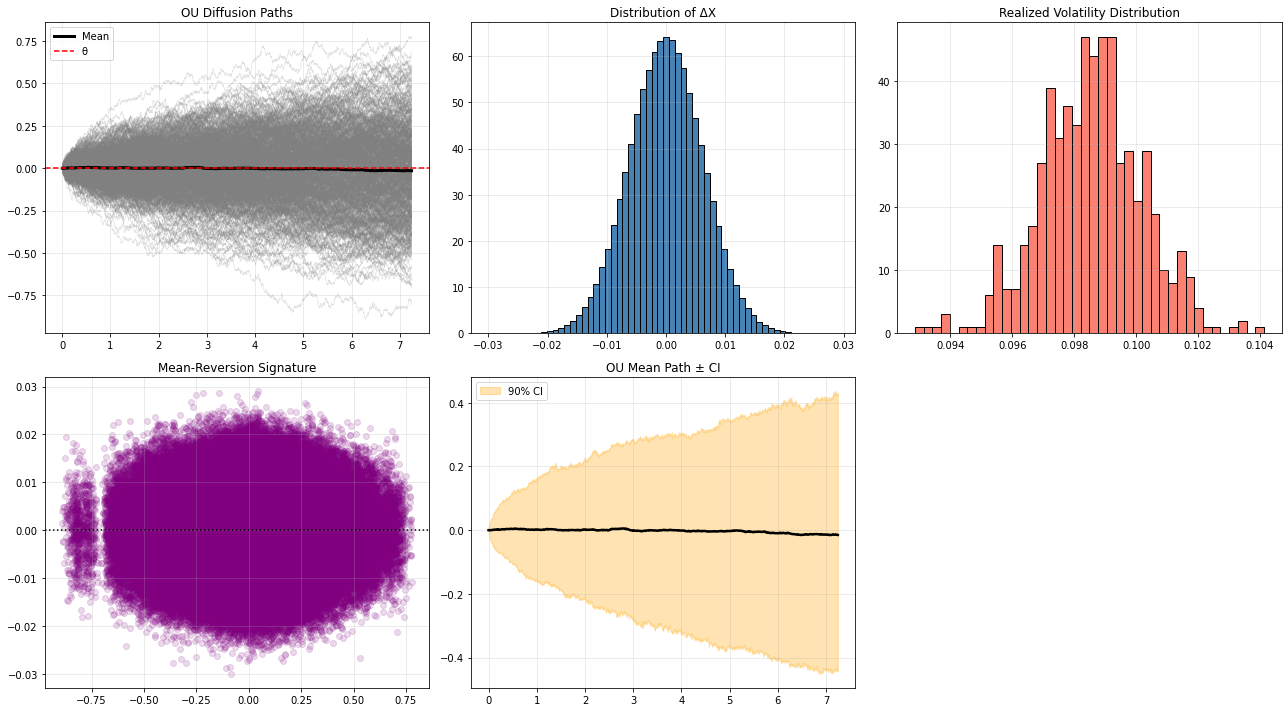

In [44]:
ou = OU(kappa=results["WLS Index"]["kappa"], theta=0, sigma=results["WLS Index"]["sigma"])
ou.plot_diagnostics(T=len(spread),paths=600,seed=42)